In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path
import re

from IPython.core.display import display_latex
from matplotlib.pyplot import axhline

from visu_utils import TASK_LIST_CLASSIFICATION, make_results_tables_per_group_size, load_classification_merged_mteb

from autorank import autorank, plot_stats, create_report, latex_table

EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)

%reload_ext autoreload
%autoreload 2


In [2]:

# load mteb classification

MTEB_BASELINES_PATH = Path("../non_sync/baselines_mteb/mteb_detailed/en_Classification.csv")

RESULTS_PATHS = [Path("../non_sync/mteb_benchmarking/results/experiments_gist_nll"),
                 Path("../non_sync/mteb_benchmarking/results/experiments_gist_mse"),
                 Path("../non_sync/mteb_benchmarking/results/experiments_gist_single_sfr_nll"),
                 ]



df_merged = load_classification_merged_mteb(MTEB_BASELINES_PATH, RESULTS_PATHS)


df_merged = df_merged.drop_duplicates()

# select only last training step for each model
df_merged = df_merged.reset_index()

indices = df_merged.sort_values('Training step').groupby('Model')['Training step'].idxmax()
df_merged = df_merged.loc[indices]
df_merged = df_merged.drop('Training step', axis=1)

display(df_merged[df_merged['Model'].str.contains('Stu')])

df_melted = df_merged.melt(id_vars=['Model', 'Model Size (Million Parameters)', 'loss', 'Dataset'],
                           value_vars=df_merged.columns[4:], var_name='Task', value_name='Accuracy')



,index,Model,Model Size (Million Parameters),loss,Dataset,AmazonCounterfactualClassification (en),AmazonPolarityClassification,AmazonReviewsClassification (en),Banking77Classification,EmotionClassification,ImdbClassification,MTOPDomainClassification (en),MTOPIntentClassification (en),MassiveIntentClassification (en),MassiveScenarioClassification (en),ToxicConversationsClassification,TweetSentimentExtractionClassification
14,14,MSE/GIST/Student-l,335.0,MSE,GIST,62.970149,89.786225,42.998,75.126623,42.745,84.5708,89.701322,68.994528,69.640215,76.526564,64.697266,58.678551
16,16,MSE/GIST/Student-m,109.0,MSE,GIST,75.791045,89.666475,44.812,86.730519,59.785,88.7748,95.652075,81.181031,77.589106,82.084734,67.739258,60.246180
18,18,MSE/GIST/Student-s,33.0,MSE,GIST,72.761194,89.430475,43.270,83.519481,55.710,87.4600,94.056088,76.808026,74.919301,80.443847,64.106445,60.710243
20,20,MSE/GIST/Student-xs,23.0,MSE,GIST,70.895522,87.459875,42.936,83.201299,56.340,84.6608,94.373005,74.863201,74.071957,80.097512,66.674805,59.824561
21,21,NLL-Single/GIST/Student-s,33.0,NLL-Single,GIST,74.253731,87.908100,42.028,84.814935,55.905,85.2536,95.066119,80.490196,75.295898,80.514459,64.350586,60.031126
22,22,NLL-Single/GIST/Student-xs,23.0,NLL-Single,GIST,76.179104,82.706925,41.050,84.876623,56.685,78.2280,94.644323,77.799818,74.374580,79.704102,67.680664,58.579513
1,1,NLL/GIST/Student-l,335.0,NLL,GIST,80.447761,50.000000,20.000,1.298701,29.050,50.0000,7.774738,0.460556,1.758574,3.227976,92.089844,28.324844
5,5,NLL/GIST/Student-m,109.0,NLL,GIST,79.626866,89.243750,45.366,88.142857,59.335,88.3712,96.117191,83.123575,78.217888,82.552118,67.700195,60.996038
9,9,NLL/GIST/Student-s,33.0,NLL,GIST,77.462687,89.770550,44.108,86.730519,57.735,88.7676,95.501596,82.088463,76.590451,80.901143,65.380859,60.243350
13,13,NLL/GIST/Student-xs,23.0,NLL,GIST,75.970149,86.018325,42.604,85.860390,57.390,82.6744,95.166439,80.164159,75.864156,80.336247,68.085938,59.629315


In [3]:

teachers = ["jamesgpt1/sf_model_e5", "WhereIsAI/UAE-Large-V1", "Salesforce/SFR-Embedding-2_R", "dunzhang/stella_en_400M_v5"]


jamesgpt1/sf_model_e5 73.95916666666666
WhereIsAI/UAE-Large-V1 75.5775
Salesforce/SFR-Embedding-2_R 89.04666666666668
dunzhang/stella_en_400M_v5 86.67333333333333


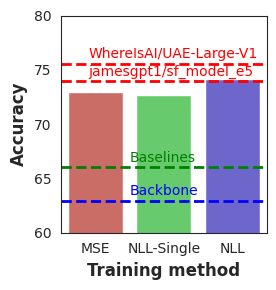

In [20]:
sns.set_style("white")

low, high = 16, 30

xs_results = df_melted[
        (df_melted['Model Size (Million Parameters)'] >= low) & (
                df_melted['Model Size (Million Parameters)'] <= high)].copy()

baselines = xs_results[xs_results['loss'].str.contains('MTEB')]['Accuracy'].mean()
backbone_perfs = xs_results[xs_results['Model'].str.contains('snowflake')]['Accuracy'].mean()
# also loss not MTEB
xs_results = xs_results[~xs_results['loss'].str.contains('MTEB')]

teachers_df = df_melted[df_melted['Model'].isin(teachers)]

teachers_perfs = []
for teacher in teachers:
    teacher_perfs = teachers_df[teachers_df['Model'] == teacher]['Accuracy'].mean()
    teachers_perfs.append((teacher, teacher_perfs))


# xs_results = xs_results[~xs_results['Dataset'].str.contains('MTEB')]

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(data=xs_results, x="loss", y="Accuracy", errorbar=None, ax=ax, alpha=1, hue="loss", palette="hls")
ax.axhline(backbone_perfs, color='blue', linestyle='--', lw=2)
ax.annotate('Backbone', (0.5, backbone_perfs + 0.5), color='blue')

ax.axhline(baselines, color='green', linestyle='--', lw=2)
ax.annotate('Baselines', (0.5, baselines + 0.5), color='green')
plt.ylim(60, 80)

ax.set_xlabel('Training method', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')



# make 4 levels of red
colors = ['r','r', 'r', 'r']
for i, (teacher, perf) in enumerate(teachers_perfs):
    print(teacher, perf)
    ax.axhline(perf, color=colors[i], linestyle='--', lw=2)
    ax.annotate(teacher, (-0.10, perf + 0.5), color=colors[i])


# export
fig.tight_layout()
fig.savefig(EXPORT_PATH_FIG / f"classification_against_single_{low}_{high}.pdf", bbox_inches='tight')




